# Homework 5 - USA Airport Flight Analysis

In [1]:
import pandas as pd
from typing import Dict, Any, List, Tuple, Set
from collections import defaultdict
import dash
from dash import dcc, html, dash_table
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import io
import base64
import numpy as np

## EDA

We conducted an Exploratory Data Analysis to understand the structure of our data. We immediately noticed that there is **missing information** related to **latitude** and **longitude**. However, the data refer to specific flights and specific dates.
What we want to do is accurately identify unique airports that lack these coordinates. 
- We identified **243** airports
- Subsequently we queried an **API key** to retrieve the coordinates of these airports.

In [ ]:

file_path = 'archive_usa_airport/Airports2.csv'
df = pd.read_csv(file_path)
df.isna().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

In [ ]:

def find_missing_coordinates(df: pd.DataFrame) -> Tuple[Set[Tuple[str, str]], int]:
    """
    Find the airports with missing data.
    """
    missing_org = df[(df['Org_airport_lat'].isna() & df['Org_airport_long'].isna())]
    missing_dest = df[(df['Dest_airport_lat'].isna() & df['Dest_airport_long'].isna())]

    unique_origin = set(zip(missing_org['Origin_airport'], missing_org['Origin_city']))
    unique_dest = set(zip(missing_dest['Destination_airport'], missing_dest['Destination_city']))

    unique_airports = unique_origin.union(unique_dest)
    return unique_airports, len(unique_airports)
unique_airports, missing_count = find_missing_coordinates(df)
print(f"Number of airports with missing coordinates: {missing_count}")




Number of airports with missing coordinates: 243


The airports with missing coordinates were identified and saved in a CSV file (`airports_without_coordinates.csv`).
This file was used as input to query the Open Cage API.
For each airport:
- A request was sent to the API providing the airport code or city.
- The API returned the corresponding coordinates (latitude and longitude).
- The obtained results extracted from the the `cage.py` file were saved in the file `airport_coordinates_.csv`.


In [ ]:
def export_missing_airports(airports: Set[Tuple[str, str]], output_file: str) -> None:
    """
    Export the missing airports to a CSV file. In order to fetch coordinates through API
    """
    df_missing = pd.DataFrame(list(airports), columns=['Airport Code', 'City'])
    df_missing.to_csv(output_file, index=False, sep=';')

export_missing_airports(unique_airports, 'archive_usa_airport/airports_without_coordinates.csv')



Subsequently, we use the dictionary **`airport_mapping`**, which associates each airport code with its corresponding coordinates. The dictionary was created the **`airport_coordinates_.csv`**file. It allows us to quickly look up the coordinates of an airport given its code (**`airport_code`**).  
The missing coordinates in the columns **`Org_airport_lat`**, **`Org_airport_long`**, **`Dest_airport_lat`**, and **`Dest_airport_long`** are filled using the **`airport_mapping`** dictionary.

In [ ]:

coordinates_file = 'archive_usa_airport/airport_coordinates_.csv'
coordinates_df = pd.read_csv(coordinates_file, sep=';')

def create_airport_mapping(coordinates_df: pd.DataFrame) -> Dict:
    """
    A mapping of airport codes to their corresponding coordinates.
    """
    return coordinates_df.set_index('airport_code')[['latitude', 'longitude']].to_dict(orient='index')

airport_mapping = create_airport_mapping(coordinates_df)

def fill_missing_coordinates(df: pd.DataFrame, airport_mapping: Dict) -> pd.DataFrame:


    df['Org_airport_lat'] = df['Org_airport_lat'].fillna(
        df['Origin_airport'].map(lambda x: airport_mapping.get(x, {}).get('latitude'))
    )
    df['Org_airport_long'] = df['Org_airport_long'].fillna(
        df['Origin_airport'].map(lambda x: airport_mapping.get(x, {}).get('longitude'))
    )

    df['Dest_airport_lat'] = df['Dest_airport_lat'].fillna(
        df['Destination_airport'].map(lambda x: airport_mapping.get(x, {}).get('latitude'))
    )
    df['Dest_airport_long'] = df['Dest_airport_long'].fillna(
        df['Destination_airport'].map(lambda x: airport_mapping.get(x, {}).get('longitude'))
    )

    return df


df_final = fill_missing_coordinates(df, airport_mapping)
df_final.isna().sum()

Origin_airport            0
Destination_airport       0
Origin_city               0
Destination_city          0
Passengers                0
Seats                     0
Flights                   0
Distance                  0
Fly_date                  0
Origin_population         0
Destination_population    0
Org_airport_lat           0
Org_airport_long          0
Dest_airport_lat          0
Dest_airport_long         0
dtype: int64

In [ ]:
df_final

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,42.026757,-93.617045
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606798,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",281,969,51,119,2009-02-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606799,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",245,1026,54,119,2009-11-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606800,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",363,1273,67,119,2009-08-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606801,CGI,TBN,"Cape Girardeau, MO","Fort Leonard Wood, MO",2,19,1,146,2009-08-01,93712,46457,37.225300,-89.570801,37.741600,-92.140701


## 1. Flight Network Analysis (Q1)

### 1.1 analyze_graph_feature


In this section we present the **`analyze_graph_features`** function, which integrates the following classes:

1. **`flight_network.py`**: This class constructs the USA flight network  as a directed graph, where each node represents an airport, and each directed edge represents a flight from one airport to another.

2. **`GraphAnalysis.py`**: This class analyze the network, calculate key metrics, and identify hubs. Specifically It computes : 
   - Number of Nodes and Edges.
   - Network Density.
   - Degree Metrics: both in-degree and out-degree for each airport.
   - key hubs in the network. The 90th percentile is used as threshold for identifying airports with the highest degree

In [ ]:
from auxiliary_files.flight_network import FlightNetwork
from auxiliary_files.GraphAnalysis import GraphAnalysis
from typing import Dict

def analyze_graph_features(network: FlightNetwork) -> Dict:
   
    
    graph_analysis = GraphAnalysis(network)

    
    n_nodes = network.graph.number_of_nodes()
    n_edges = network.graph.number_of_edges()
    density = graph_analysis.calculate_graph_density(n_nodes, n_edges)

   
    in_degrees, out_degrees = graph_analysis.get_degree_metrics()

    
    hubs = graph_analysis.identify_hub_airports()
    hubs_table = graph_analysis.create_hubs_table(hubs, in_degrees, out_degrees)

    return {
        'n_airports': n_nodes,
        'n_flights': n_edges,
        'density': density,
        'in_degrees': in_degrees,
        'out_degrees': out_degrees,
        'hubs_table': hubs_table,
    }




### 1.2 summarize_graph_features

This code sets up a Dash web application that visualizes and analyzes an air travel network:

- A FlightNetwork object is created, representing the flight network graph.
- A GraphAnalysis object is created to analyze the network's features

The app displays :
- A summary of the network (number of airports, flights, and graph density).
- In-degree and out-degree distribution plots (showing how airports are connected).
- A table of top hub airports (sorted by their total degree).

Callback: Automatically updates the app's summary, plots, and table based on the analysis results.

In [ ]:
app = dash.Dash(__name__)

flightnetwork = FlightNetwork()

origin_airports = df_final['Origin_airport']
destination_airports = df_final['Destination_airport']
distances=df["Distance"]

flightnetwork.add_nodes_and_edges(origin_airports, destination_airports, distances)
graph_analysis = GraphAnalysis(flightnetwork)

app.layout = html.Div([
    html.H1("Flight Network Analysis"),
    html.Div(id="summary-text"),
    html.Div([
        html.Div([
            html.H3("In-degree Distribution"),
            html.Img(id="in-degree-plot", style={"width": "100%", "height": "auto"})
        ], style={"width": "48%", "display": "inline-block"}),
        html.Div([
            html.H3("Out-degree Distribution"),
            html.Img(id="out-degree-plot", style={"width": "100%", "height": "auto"})
        ], style={"width": "48%", "display": "inline-block"})
    ], style={"display": "flex", "justify-content": "space-between", "margin-top": "30px"}),
    html.Div([
        html.H3("Top Hubs (Airports with highest degree)"),
        dash_table.DataTable(
            id='hubs-table',
            columns=[{"name": col, "id": col} for col in ['Airport', 'In-degree', 'Out-degree', 'Total degree']],
            style_table={'height': '300px', 'overflowY': 'auto'}
        ),
    ], style={"margin-top": "40px"})
])

@app.callback(
    [
        dash.dependencies.Output("summary-text", "children"),
        dash.dependencies.Output("in-degree-plot", "src"),
        dash.dependencies.Output("out-degree-plot", "src"),
        dash.dependencies.Output("hubs-table", "data"),
    ],
    [dash.dependencies.Input("summary-text", "children")]
)
def summarize_graph_feature(_):
    
    results = analyze_graph_features(flightnetwork)
    
    summary_text = f"""
        Network Analysis Report:
        - Number of Airports (Nodes): {results['n_airports']}
        - Number of Flights (Edges): {results['n_flights']}
                - Graph Density: {results['density']:.4f}
    """
    
    in_degree_image = graph_analysis.get_image_from_figure(graph_analysis.plot_degree_distribution(list(results['in_degrees'].values()), "In-degree"))
    
    out_degree_image = graph_analysis.get_image_from_figure(graph_analysis.plot_degree_distribution(list(results['out_degrees'].values()), "Out-degree"))
    
    return summary_text.strip(), in_degree_image, out_degree_image, results['hubs_table'].to_dict('records')

if __name__ == "__main__":
    app.run_server(debug=True)

## 1.3

Now let's dive deeper into the analysis of the dataset. Do the following:

- Compute total passenger flow between origin and destination cities. 
- Identify and visualize the busiest routes by passenger traffic.
- Calculate the average passengers per flight for each route and highlight under/over-utilized connections.
- Create an interactive map visualizing the geographic spread of the flight network.

### Compute total passenger flow between origin and destination cities.

In [ ]:

def compute_passenger_flow_cities(data):

    total_passenger_flow = data.groupby(['Origin_city', 'Destination_city'])['Passengers'].sum().reset_index()
    total_passenger_flow = total_passenger_flow.sort_values(by='Passengers', ascending=False)
    return total_passenger_flow

passenger_flow_cities = compute_passenger_flow_cities(df_final)
display(passenger_flow_cities)

,Origin_city,Destination_city,Passengers
7122,"Dallas, TX","Houston, TX",38295025
12391,"Houston, TX","Dallas, TX",37989016
13585,"Kahului, HI","Honolulu, HI",32364664
12259,"Honolulu, HI","Kahului, HI",29744742
16133,"Los Angeles, CA","Honolulu, HI",28964232
...,...,...,...
14206,"Klamath Falls, OR","Anchorage, AK",0
14218,"Klamath Falls, OR","Roseburg, OR",0
25915,"Seattle, WA","West Palm Beach, FL",0
14226,"Knoxville, TN","Albany, GA",0


### Identify and visualize the busiest routes by passenger traffic.

In [ ]:

top_flights = (
    df_final.groupby(['Origin_airport', 'Destination_airport', 'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long'])
    .agg({'Passengers': 'sum', 'Flights': 'sum', 'Seats': 'sum'}) 
    .reset_index()
    .sort_values(by='Passengers', ascending=False)
)

In [ ]:
def compute_passenger_flow_airports(df_final):

    return top_flights

In [ ]:



def plot_busiest_routes_airports(passenger_flow):
    
    passenger_flow['Route'] = passenger_flow['Origin_airport'] + " - " + passenger_flow['Destination_airport']

    
    top_routes = passenger_flow.sort_values(by='Passengers', ascending=False).head(45)

    
    plt.figure(figsize=(12, 8))

    
    norm = plt.Normalize(top_routes['Passengers'].min(), top_routes['Passengers'].max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    
    sns.barplot(x='Passengers', y='Route', data=top_routes, palette="viridis", errorbar=None)


    
    plt.title('Busiest Routes by Passenger Traffic (Airports)', fontsize=14)
    plt.xlabel('Total Passengers', fontsize=12)
    plt.ylabel('Routes (Origin - Destination)', fontsize=12)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  
    

    
    plt.legend([], frameon=False)

    
    plt.tight_layout()
    plt.savefig("busiest_routes_airportsv.png", format='png')
    
    
    
    plt.show()

In [ ]:

passenger_flow_airports = compute_passenger_flow_airports(df_final)

display(passenger_flow_airports[['Origin_airport', 'Destination_airport', 'Passengers']])



,Origin_airport,Destination_airport,Passengers
25706,OGG,HNL,32364612
15625,HNL,OGG,29744742
19159,LAX,HNL,28964154
15606,HNL,LAX,28632161
18874,LAS,LAX,26333721
...,...,...,...
19487,LBL,PIA,0
19489,LBL,RFD,0
19491,LBL,SDM,0
19496,LBL,YIP,0


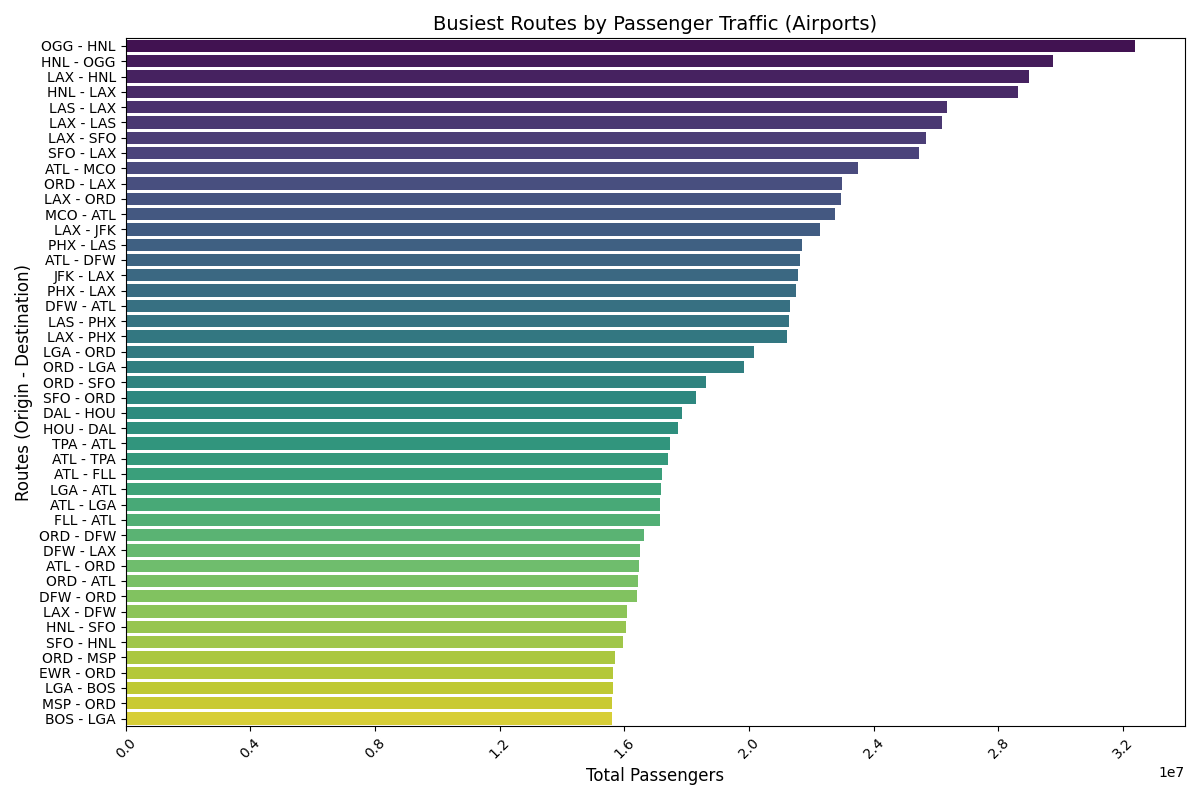

### Calculate the average passengers per flight for each route and highlight under/over-utilized connections.

The San Francisco International Airport (SFO) and Los Angeles International Airport (LAX) stand out as the most significant airports in terms of the number of flights and of passenger per flight.

In our code, we aimed to analyze the efficiency of airline flights, considering that the data we have is aggregated by day. Each row in our dataset represents the flights operated on a specific route on a given day, and includes the number of flights operated, the number of available seats, and the number of passengers. Here there are the step followed:

*total daily capacity calculation*:
First, we multiplied the number of seats per flight (Seats) by the number of flights operated. This gave us the total capacity for each route, which tells us how many seats were available in total for that route.

*efficiency*:
Next, we calculated the efficiency of each flight, which indicates how much of the available capacity was actually used. If the total number of seats (Total_Seats) is 0 (e.g., there are no flights), the efficiency is set to 0. Otherwise, we calculated the ratio of passengers to the total capacity of the flights. However, we imposed a limit of 1 for the efficiency, ensuring it could never exceed 100% (in case the number of passengers exceeded the available seats).

*passengers per flight*:
Another important step was to calculate passengers per flight, which is the average number of passengers per flight.

In [ ]:


def passangerperflight(df_final):
     
    df_final['Total_Seats'] = df_final['Seats'] * df_final['Flights']
    df_final['Efficiency'] = np.where(
    df_final['Total_Seats'] == 0,
    0,
    np.minimum(df_final['Passengers'] / df_final['Total_Seats'], 1)
)
  


    
    df_final['Passengers_per_Flight'] = np.where(
        df_final['Flights'] == 0, 
        0, 
        df_final['Passengers'] / df_final['Flights']
    )
    
    
    df_final_sorted = df_final.sort_values(by=['Flights','Passengers_per_Flight'], ascending=[False, False])

    
    df_final_sorted['Route'] = df_final_sorted['Origin_airport'] + " - " + df_final_sorted['Destination_airport']
    
   
    return df_final_sorted

sorted_df = passangerperflight(df_final)

display(sorted_df)


,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long,Total_Seats,Efficiency,Passengers_per_Flight,Route
2975875,SFO,LAX,"San Francisco, CA","Los Angeles, CA",83153,142128,1128,337,1994-12-01,7666396,23179000,37.618999,-122.375000,33.942501,-118.407997,160320384,0.000519,73.717199,SFO - LAX
3438039,LAX,SFO,"Los Angeles, CA","San Francisco, CA",80450,141876,1126,337,1994-12-01,23179000,7666396,33.942501,-118.407997,37.618999,-122.375000,159752376,0.000504,71.447602,LAX - SFO
1153503,HNL,OGG,"Honolulu, HI","Kahului, HI",73014,147062,1058,100,1994-08-01,869959,112610,21.318701,-157.921997,20.898600,-156.429993,155591596,0.000469,69.011342,HNL - OGG
1643395,OGG,HNL,"Kahului, HI","Honolulu, HI",77011,146784,1056,100,1994-08-01,112610,869959,20.898600,-156.429993,21.318701,-157.921997,155003904,0.000497,72.927083,OGG - HNL
2980169,SFO,LAX,"San Francisco, CA","Los Angeles, CA",77531,131544,1044,337,1995-01-01,7704224,23203726,37.618999,-122.375000,33.942501,-118.407997,137331936,0.000565,74.263410,SFO - LAX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3602551,CVG,COS,"Cincinnati, OH","Colorado Springs, CO",0,0,0,1078,2002-12-01,2050030,566091,39.048801,-84.667801,38.805801,-104.700996,0,0.000000,0.000000,CVG - COS
3602586,ORD,COS,"Chicago, IL","Colorado Springs, CO",0,0,0,911,2002-01-01,18490270,566091,41.978600,-87.904800,38.805801,-104.700996,0,0.000000,0.000000,ORD - COS
3603050,CVG,COS,"Cincinnati, OH","Colorado Springs, CO",0,0,0,1078,2003-08-01,2066256,572399,39.048801,-84.667801,38.805801,-104.700996,0,0.000000,0.000000,CVG - COS
3603057,CVG,COS,"Cincinnati, OH","Colorado Springs, CO",0,0,0,1078,2003-02-01,2066256,572399,39.048801,-84.667801,38.805801,-104.700996,0,0.000000,0.000000,CVG - COS


Among the flights with the highest efficiency, we can highlight those with a high number of passengers. In other words, we focus on flights that not only make optimal use of available seats (high efficiency) but also carry a significant number of passengers.
We identified flights where the number of passengers exceeds available seats, maybe due to overbooking strategy made by some companies

In [ ]:


def passangerperflight(df_final):
     
    df_final['Total_Seats'] = df_final['Seats'] * df_final['Flights']
    df_final['Efficiency'] = np.where(
    df_final['Total_Seats'] == 0,
    0,
    np.minimum(df_final['Passengers'] / df_final['Total_Seats'], 1)
)
  


    
    df_final['Passengers_per_Flight'] = np.where(
        df_final['Flights'] == 0, 
        0, 
        df_final['Passengers'] / df_final['Flights']
    )
    
    
    df_final_sorted = df_final.sort_values(by=['Efficiency','Flights'], ascending=[False, False])

    
    df_final_sorted['Route'] = df_final_sorted['Origin_airport'] + " - " + df_final_sorted['Destination_airport']
    
   
    return df_final_sorted

sorted_df = passangerperflight(df_final)

display(sorted_df)





,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long,Total_Seats,Efficiency,Passengers_per_Flight,Route
3341600,TTN,PHL,"Trenton, NJ","Philadelphia, PA",1349,122,3,37,1998-11-01,331474,11020546,40.276699,-74.813499,39.871899,-75.241096,366,1.0,449.666667,TTN - PHL
292,EKO,RDM,"Elko, NV","Bend, OR",124,124,1,362,1993-02-01,40259,87688,40.824902,-115.792000,44.254101,-121.150002,124,1.0,124.000000,EKO - RDM
302,SEA,RDM,"Seattle, WA","Bend, OR",18,18,1,228,1994-01-01,5485752,90902,47.449001,-122.308998,44.254101,-121.150002,18,1.0,18.000000,SEA - RDM
418,EUG,RDM,"Eugene, OR","Bend, OR",18,18,1,103,1996-01-01,306326,98602,44.124599,-123.211998,44.254101,-121.150002,18,1.0,18.000000,EUG - RDM
549,PDX,RDM,"Portland, OR","Bend, OR",18,18,1,116,1997-06-01,1800340,101660,45.588699,-122.598000,44.254101,-121.150002,18,1.0,18.000000,PDX - RDM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3602551,CVG,COS,"Cincinnati, OH","Colorado Springs, CO",0,0,0,1078,2002-12-01,2050030,566091,39.048801,-84.667801,38.805801,-104.700996,0,0.0,0.000000,CVG - COS
3602586,ORD,COS,"Chicago, IL","Colorado Springs, CO",0,0,0,911,2002-01-01,18490270,566091,41.978600,-87.904800,38.805801,-104.700996,0,0.0,0.000000,ORD - COS
3603050,CVG,COS,"Cincinnati, OH","Colorado Springs, CO",0,0,0,1078,2003-08-01,2066256,572399,39.048801,-84.667801,38.805801,-104.700996,0,0.0,0.000000,CVG - COS
3603057,CVG,COS,"Cincinnati, OH","Colorado Springs, CO",0,0,0,1078,2003-02-01,2066256,572399,39.048801,-84.667801,38.805801,-104.700996,0,0.0,0.000000,CVG - COS


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns

#Seat Efficiency
def calculate_efficiency(df):
    df['Total_Seats'] = df['Seats'] * df['Flights']
    df['Efficiency'] = np.where(
        df['Total_Seats'] == 0,
        0,
        np.minimum(df['Passengers'] / df['Total_Seats'], 1)
    )
    return df


def remove_bidirectional_duplicates(data):
    seen = set()
    unique_routes = []
    for _, row in data.iterrows():
        route = tuple(sorted([row['Origin_airport'], row['Destination_airport']]))
        if route not in seen:
            seen.add(route)
            unique_routes.append(row)
    return pd.DataFrame(unique_routes)


def plot_top_flights(df, top_n=30):
    
    top_flights = (
        df.groupby(['Origin_airport', 'Destination_airport', 'Org_airport_lat', 'Org_airport_long',
                    'Dest_airport_lat', 'Dest_airport_long'])
        .agg({'Passengers': 'sum', 'Flights': 'sum', 'Seats': 'sum', 'Efficiency': 'mean'})
        .reset_index()
        .sort_values(by='Passengers', ascending=False)
    )

    
    top_flights['Passengers_per_Flight'] = top_flights['Passengers'] / top_flights['Flights']

    
    top_flights = remove_bidirectional_duplicates(top_flights.head(top_n))

    
    palette = sns.color_palette("husl", 8)

   
    fig = go.Figure()

    
    fig.add_trace(
        go.Scattergeo(
            lon=top_flights['Org_airport_long'],
            lat=top_flights['Org_airport_lat'],
            text=top_flights.apply(
                lambda row: f"{row['Origin_airport']}<br>{row['Passengers_per_Flight']:.1f} Passengers per Flight<br>Seat Efficiency: {row['Efficiency']:.2f}", axis=1
            ),
            mode='markers',
            marker=dict(
                size=top_flights['Passengers_per_Flight'],
                color='blue',
                sizeref=max(top_flights['Passengers_per_Flight']) / 30,
                sizemode='diameter'
            ),
            name='Origin Airports'
        )
    )

    
    fig.add_trace(
        go.Scattergeo(
            lon=top_flights['Dest_airport_long'],
            lat=top_flights['Dest_airport_lat'],
            text=top_flights.apply(
                lambda row: f"{row['Destination_airport']}<br>{row['Passengers_per_Flight']:.1f} Passengers per Flight<br>Seat Efficiency: {row['Efficiency']:.2f}", axis=1
            ),
            mode='markers',
            marker=dict(
                size=top_flights['Passengers_per_Flight'],
                color='red',
                sizeref=max(top_flights['Passengers_per_Flight']) / 30,
                sizemode='diameter'
            ),
            name='Destination Airports'
        )
    )

    
    for idx, row in top_flights.iterrows():
        color = f'rgb({int(palette[idx % 8][0] * 255)}, {int(palette[idx % 8][1] * 255)}, {int(palette[idx % 8][2] * 255)})'
        fig.add_trace(
            go.Scattergeo(
                lon=[row['Org_airport_long'], row['Dest_airport_long']],
                lat=[row['Org_airport_lat'], row['Dest_airport_lat']],
                mode='lines',
                line=dict(width=2, color=color),
                opacity=0.7,
                name=f"{row['Origin_airport']} to {row['Destination_airport']}"
            )
        )

    
    fig.update_layout(
        title_text=f'Top {top_n} Flights (Passengers per Flight and Seat Efficiency)',
        showlegend=True,
        geo=dict(
            scope='usa',
            showland=True,
            landcolor='rgb(217, 217, 217)',
            projection_type='albers usa',
            coastlinecolor="Black",
            showcoastlines=True
        )
    )
    return fig


def plot_bottom_flights(df, bottom_n=15):
    
    bottom_flights = (
        df.groupby(['Origin_airport', 'Destination_airport', 'Org_airport_lat', 'Org_airport_long',
                    'Dest_airport_lat', 'Dest_airport_long'])
        .agg({'Passengers': 'sum', 'Flights': 'sum', 'Seats': 'sum', 'Efficiency': 'mean'})
        .reset_index()
        .sort_values(by='Passengers', ascending=True)
    )

    
    bottom_flights = remove_bidirectional_duplicates(bottom_flights.head(bottom_n))

    
    palette = sns.color_palette("hls", 8)

    
    fig = go.Figure()

    
    fig.add_trace(
        go.Scattergeo(
            lon=bottom_flights['Org_airport_long'],
            lat=bottom_flights['Org_airport_lat'],
            text=bottom_flights.apply(
                lambda row: f"{row['Origin_airport']}<br>{row['Passengers'] / 1e6:.1f} million Passengers<br>Efficiency: {row['Efficiency']:.2f}", axis=1
            ),
            mode='markers',
            marker=dict(size=10, color='blue'),
            name='Origin Airports'
        )
    )

   
    fig.add_trace(
        go.Scattergeo(
            lon=bottom_flights['Dest_airport_long'],
            lat=bottom_flights['Dest_airport_lat'],
            text=bottom_flights.apply(
                lambda row: f"{row['Destination_airport']}<br>{row['Passengers'] / 1e6:.1f} million Passengers<br>Efficiency: {row['Efficiency']:.2f}", axis=1
            ),
            mode='markers',
            marker=dict(size=10, color='red'),
            name='Destination Airports'
        )
    )

   
    for idx, row in bottom_flights.iterrows():
        color = f'rgb({int(palette[idx % 8][0] * 255)}, {int(palette[idx % 8][1] * 255)}, {int(palette[idx % 8][2] * 255)})'
        fig.add_trace(
            go.Scattergeo(
                lon=[row['Org_airport_long'], row['Dest_airport_long']],
                lat=[row['Org_airport_lat'], row['Dest_airport_lat']],
                mode='lines',
                line=dict(width=2, color=color),
                opacity=0.7,
                name=f"{row['Origin_airport']} to {row['Destination_airport']}"
            )
        )

    # Layout
    fig.update_layout(
        title_text=f'Bottom {bottom_n} Flights (In Terms of Passengers)',
        showlegend=True,
        geo=dict(
            scope='usa',
            showland=True,
            landcolor='rgb(217, 217, 217)',
            projection_type='albers usa',
            coastlinecolor="Black",
            showcoastlines=True
        )
    )
    return fig


In [ ]:
top_fig = plot_top_flights(df, top_n=30)
bottom_fig = plot_bottom_flights(df, bottom_n=30)


top_fig.show()
bottom_fig.show()


[top flights](images/top_flights.html)

[bottom flights](bottom_flights.html)

**Is the graph sparse or dense?** 

With respect to the maximum possible number of edges. Our graph has 0.06 as density value.This suggests that most of the possible edges are missing. Therefore, the graph is considered sparse.


**What patterns do you observe in the degree distribution?** 

For both in-degree and out-degree, we observe the same pattern: there are many airports with a low number of connections and a few airports with a very high number of edges. These high-degree airports act as hubs, which can be seen in the bottom-right part of the graph, where the airports with the most connections are clustered together. 



In [ ]:
import matplotlib.pyplot as plt

results = analyze_graph_features(flightnetwork)

in_degree_figure = graph_analysis.plot_degree_distribution(list(results['in_degrees'].values()), "In-degree")
out_degree_figure = graph_analysis.plot_degree_distribution(list(results['out_degrees'].values()), "Out-degree")


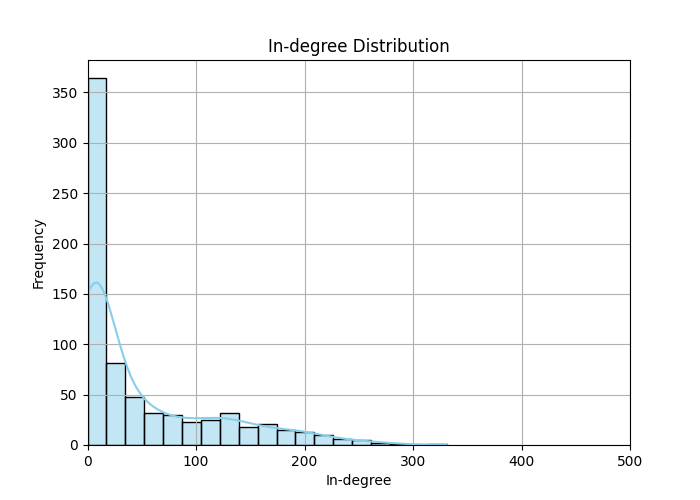
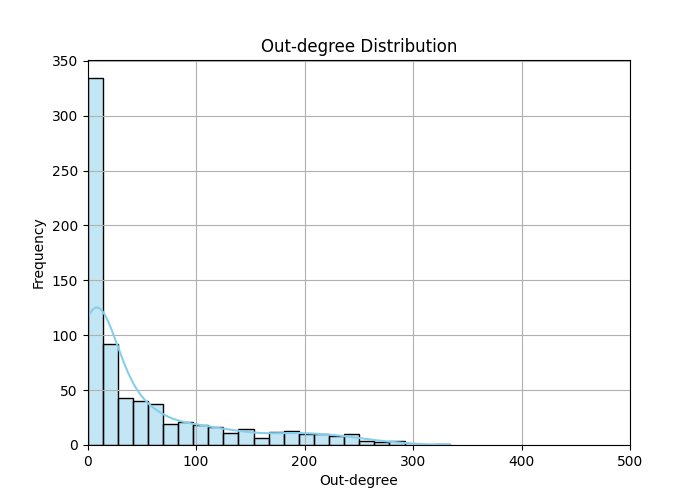

 **Which airports are identified as hubs, and why?** 

The hubs in our specific case are defined as the top 10% of airports based on their number of connections (total degree). These airports stand out for their high connectivity to other nodes in the network. From the graphical representation is possible to see that: 
- Many high-degree airports are located on the **East Coast** of the **United States**. 
- Airports in densely populated cities, such as **New York**, are major hubs due to high passenger and cargo traffic. such as **EWR** and **JFK**. 
- For example, **MEM** (Memphis International Airport) is identified as a hub. It is the second-busiest airport in the United States for cargo traffic, serving as a major logistics center. Similarly, airports like **MSP** (Minneapolis–Saint Paul International Airport) serve both as cargo hubs and significant commercial transportation centers. 

In [ ]:
from auxiliary_files.flight_network import FlightNetwork
from auxiliary_files.GraphAnalysis import GraphAnalysis
import pandas as pd
import plotly.express as px
from typing import Dict

graph_features = analyze_graph_features(flightnetwork)


in_degrees = graph_features['in_degrees']
out_degrees = graph_features['out_degrees']


all_airports = set(in_degrees.keys()).union(set(out_degrees.keys()))
total_degrees = {airport: in_degrees.get(airport, 0) + out_degrees.get(airport, 0) for airport in all_airports}

df_degrees = pd.DataFrame({
    'Origin_airport': list(total_degrees.keys()),
    'Total_degree': list(total_degrees.values())
})

df_final = df_final.drop_duplicates(subset='Origin_airport') 
df_final = df_final.merge(df_degrees, on='Origin_airport', how='left')


px.set_mapbox_access_token('your_mapbox_access_token') 

fig = px.scatter_mapbox(df_final,
                        lat='Org_airport_lat', 
                        lon='Org_airport_long',
                        size='Total_degree',  
                        color='Total_degree',  
                        hover_name='Origin_airport',
                        size_max=35,
                        title='Origin Airports by Total Degree',
                        template='plotly',
                        color_continuous_scale=px.colors.sequential.Viridis,
                        opacity=0.5)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=3,
    mapbox_center={"lat": df_final['Org_airport_lat'].mean(),
                   "lon": df_final['Org_airport_long'].mean()},
    showlegend=True
)


fig.show()


[hub_densitymap](images/hub_mapbox.html)


**What are the busiest routes in terms of passenger traffic?**

Busiest Routes in Terms of Passenger Traffic The busiest routes in terms of passenger traffic include: 
- OGG (Kahului, Hawaii)-- HNL (Kahului, Hawaii) 
- HNL (Honolulu, Hawaii) -- OGG (Kahului, Hawaii)-- 
- LAX (Los Angeles, California) -- HNL (Honolulu, Hawaii) 
- HNL (Honolulu, Hawaii) -- LAX (Los Angeles, California) 
- LAS (Las Vegas, Nevada) -- LAX (Los Angeles, California) 

This is clearly influenced by two key factors: 
1. The high population density of the cities hosting these airports, such as Los Angeles. 
2. The high tourist demand for destinations like Hawaii (Honolulu and Kahului) and Las Vegas, which are major vacation and leisure hubs


**Map**

We created a map that visually represents some of the flights, we'll color the nodes (airports) differently depending on whether they are the origin or the destination airport. Specifically, the origin airports will be colored green, the destination airports will be colored red, and the flight routes (lines) between the airports will be colored gray.

- <span style="color: green;">Origin Airports</span>
- <span style="color: red;">Destination Airports</span>
- <span style="color: Edges;">Edges </span>





In [ ]:
import pandas as pd
import random
from datetime import datetime


import folium

def plot_flights_on_map(df_final, top_n=30):
    
    top_flights = (
        df_final.groupby(['Origin_airport', 'Destination_airport', 'Org_airport_lat', 'Org_airport_long',
                          'Dest_airport_lat', 'Dest_airport_long'])
        .agg({'Passengers': 'sum', 'Flights': 'sum', 'Seats': 'sum'})
        .reset_index()
        .sort_values(by='Passengers', ascending=False)
    )

    
   
    top_flights['Passengers_per_Flight'] = np.where(
        top_flights['Flights'] == 0, 0, top_flights['Passengers'] / top_flights['Flights']
    )

    top_flights['Seat_Efficiency'] = np.where(
        top_flights['Seats'] == 0, 0, top_flights['Passengers'] / top_flights['Seats']
    )

    
    def remove_bidirectional_duplicates(data):
        seen = set()
        unique_routes = []
        for _, row in data.iterrows():
            route = tuple(sorted([row['Origin_airport'], row['Destination_airport']]))
            if route not in seen:
                seen.add(route)
                unique_routes.append(row)
        return pd.DataFrame(unique_routes)

    top_flights = remove_bidirectional_duplicates(top_flights.head(top_n))

    
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

    
    for idx, row in top_flights.iterrows():
        origin_marker = folium.CircleMarker(
            location=[row['Org_airport_lat'], row['Org_airport_long']],
            radius=8,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.6,
            popup=f"Origin: {row['Origin_airport']}<br>Passengers per Flight: {row['Passengers_per_Flight']:.1f}<br>Seat Efficiency: {row['Seat_Efficiency']:.2f}"
        ).add_to(m)

        destination_marker = folium.CircleMarker(
            location=[row['Dest_airport_lat'], row['Dest_airport_long']],
            radius=8,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=f"Destination: {row['Destination_airport']}<br>Passengers per Flight: {row['Passengers_per_Flight']:.1f}<br>Seat Efficiency: {row['Seat_Efficiency']:.2f}"
        ).add_to(m)

        
        folium.PolyLine(
            locations=[(row['Org_airport_lat'], row['Org_airport_long']), 
                       (row['Dest_airport_lat'], row['Dest_airport_long'])],
            color='grey', weight=2, opacity=0.6
        ).add_to(m)

    
    return m

flight_map = plot_flights_on_map(df_final, top_n=5000)

flight_map


[flight_network_map](https://raw.githack.com/beatricemazz/PCS2.github.io/refs/heads/main/images/bottom_flights.html)